In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import requests
from PIL import Image

from tqdm import tqdm_notebook
import selenium
import nltk
import seaborn as sns
from tensorflow.keras import preprocessing
from wordcloud import WordCloud, STOPWORDS
from eunjeon import Mecab

from konlpy.tag import Okt

import matplotlib.pyplot as plt
%matplotlib inline

## - 데이터 불러오기 및 분석하기

In [2]:
import re
import json
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

df_union = pd.read_csv('./data_nsmc/ratings_train.txt', sep='\t', header = 0, quoting = 3)
df_union.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print('전체 데이터 개수 : ', len(df_union))

전체 데이터 개수 :  150000


In [4]:
cmt_length = df_union['document'].astype(str).apply(len)
cmt_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

Text(0, 0.5, 'Number of review')

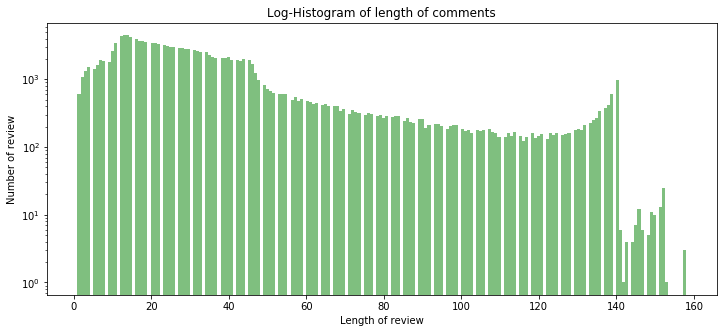

In [5]:
# 그래프
plt.figure(figsize=(12,5))
plt.hist(cmt_length, bins=200, alpha=0.5, color='g', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of comments')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [6]:
print('댓글 길이 최댓값 ', np.max(cmt_length))
print('댓글 길이 최솟값 ', np.min(cmt_length))
print('댓글 길이 평균값 ', np.mean(cmt_length))
print('댓글 길이 표준편차 ', np.std(cmt_length))
print('댓글 길이 중간값 ', np.median(cmt_length))
print('댓글 길이 제1사분위 ', np.percentile(cmt_length, 25))
print('댓글 길이 제3사분위 ', np.percentile(cmt_length, 75))

댓글 길이 최댓값  158
댓글 길이 최솟값  1
댓글 길이 평균값  35.23749333333333
댓글 길이 표준편차  29.582262651516178
댓글 길이 중간값  27.0
댓글 길이 제1사분위  16.0
댓글 길이 제3사분위  42.0


{'whiskers': [<matplotlib.lines.Line2D at 0x2a8ed9a2198>,
 'caps': [<matplotlib.lines.Line2D at 0x2a8ed9a2898>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a8ed9a2048>],
 'medians': [<matplotlib.lines.Line2D at 0x2a8ed9a2f28>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a8ed9aa5c0>],
 'means': [<matplotlib.lines.Line2D at 0x2a8ed9aa2b0>]}

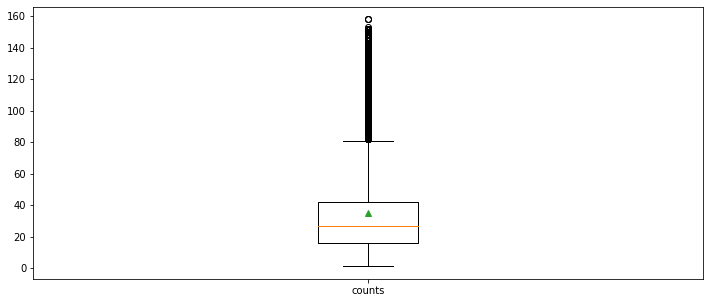

In [7]:
plt.figure(figsize=(12,5))
plt.boxplot(cmt_length, labels=['counts'], showmeans=True)

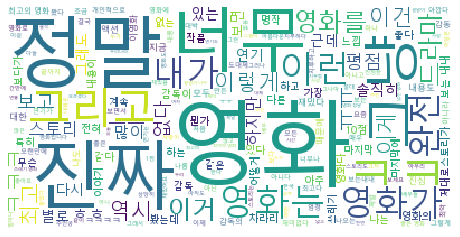

In [8]:
path = 'c:/Windows/Fonts/malgun.ttf'

train_cmt = [cmt for cmt in df_union['document'] if type(cmt) is str]
wordcloud = WordCloud(font_path=path,
                      relative_scaling=0.5,
                      background_color = 'white').generate(' '.join(train_cmt))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

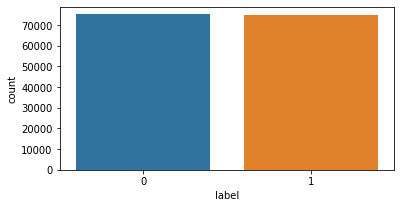

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(df_union['label'])

In [10]:
print('긍정적 반응 개수', df_union['label'].value_counts()[1])
print('부정적 반응 개수', df_union['label'].value_counts()[0])

긍정적 반응 개수 74827
부정적 반응 개수 75173


Text(0.5, 0, 'Number of comments')

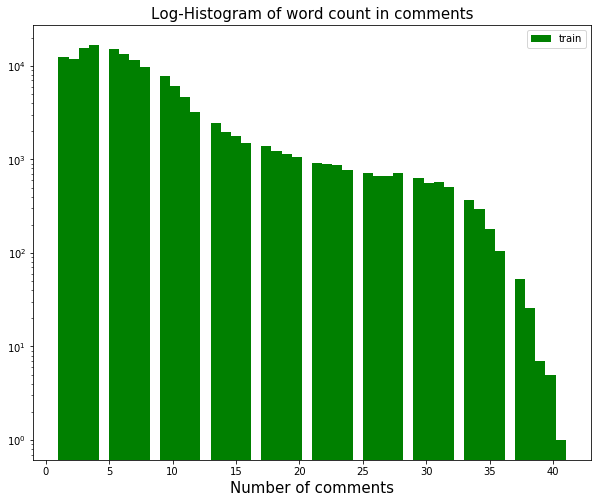

In [11]:
word_counts = df_union['document'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(10, 8))
plt.hist(word_counts, bins=50, facecolor='g', label='train')
plt.title('Log-Histogram of word count in comments', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.xlabel('Number of comments', fontsize=15)

In [12]:
print('댓글 단어 개수 최댓값 ', np.max(word_counts))
print('댓글 단어 개수 최솟값 ', np.min(word_counts))
print('댓글 단어 개수 평균값 ', np.mean(word_counts))
print('댓글 단어 개수 표준편차 ', np.std(word_counts))
print('댓글 단어 개수 중간값 ', np.median(word_counts))
print('댓글 단어 개수 제1사분위 ', np.percentile(word_counts, 25))
print('댓글 단어 개수 제3사분위 ', np.percentile(word_counts, 75))

댓글 단어 개수 최댓값  41
댓글 단어 개수 최솟값  1
댓글 단어 개수 평균값  7.58494
댓글 단어 개수 표준편차  6.514041131514803
댓글 단어 개수 중간값  6.0
댓글 단어 개수 제1사분위  3.0
댓글 단어 개수 제3사분위  9.0


## - 데이터 전처리

In [13]:
okt = Okt()

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [14]:
def preprocessing(data, okt, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    #words = mecab.morphs(data_text)
    words = okt.morphs(data_text)
    if remove_stopwords:
        words = [token for token in words]

    return words

In [15]:
#mecab = Mecab()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

docs = []

In [16]:
for review in tqdm_notebook(df_union['document']):
    if type(review) == str:
        docs.append(preprocessing(review, okt, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        docs.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
train_sequences = tokenizer.texts_to_sequences(docs)
word_vocab = tokenizer.word_index

In [18]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

In [19]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data_nsmc/word_dict/input.npy', 'wb'), train_inputs)
np.save(open('./data_nsmc/word_dict/label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data_nsmc/word_dict/data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

In [20]:
docs

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '의',
  '익살스런',
  '연기',
  '가',
  '돋보였던',
  '영화',
  '스파이더맨',
  '에서',
  '늙어',
  '보이기만',
  '했던',
  '커스틴',
  '던스트',
  '가',
  '너무나도',
  '이뻐',
  '보였다'],
 ['막',
  '걸음',
  '마',
  '뗀',
  '세',
  '부터',
  '초등학교',
  '학년',
  '생인',
  '살용',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '도',
  '아까',
  '움'],
 ['원작', '의', '긴장감', '을', '제대로', '살려내지못', '했다'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '이',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫겟다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '이',
  '드라마',
  '는',
  '가족',
  '도',
  '없다',
  '연기',
  '못',
  '하는',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '이', '없는데도', '재미', '있는', '몇', '안되는', '영화'],
 ['왜케',
  '평점',
  '이',
  '낮은건데',
  '꽤',
  '볼',
  '만',
  '한'

## 형태소 정보 추가 

In [21]:
def tokenize(doc):
    return ['/'.join(t) for t in okt.pos(doc)]

In [22]:
def pos_preprocessing(data, okt, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    #words = okt.pos(data_text, join=True)
    words = tokenize(data_text)
    if remove_stopwords:
        words = [token for token in words]

    return words

In [23]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

docs = []

for review in tqdm_notebook(df_union['document']):
    if type(review) == str:
        docs.append(pos_preprocessing(review, okt, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        docs.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
train_sequences = tokenizer.texts_to_sequences(docs)
word_vocab = tokenizer.word_index

In [25]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data_nsmc/word_dict/pos_input.npy', 'wb'), train_inputs)
np.save(open('./data_nsmc/word_dict/pos_label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data_nsmc/word_dict/pos_data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

In [26]:
docs

[['아/Exclamation', '더빙/Noun', '진짜/Noun', '짜증나네요/Adjective', '목소리/Noun'],
 ['흠/Noun',
  '포스터/Noun',
  '보고/Noun',
  '초딩/Noun',
  '영화/Noun',
  '줄/Noun',
  '오버/Noun',
  '연기/Noun',
  '조차/Josa',
  '가볍지/Adjective',
  '않구나/Verb'],
 ['너/Modifier',
  '무재/Noun',
  '밓었/Noun',
  '다그/Noun',
  '래서/Noun',
  '보는것을/Verb',
  '추천/Noun',
  '한/Josa',
  '다/Adverb'],
 ['교도소/Noun',
  '이야기/Noun',
  '구먼/Noun',
  '솔직히/Adjective',
  '재미/Noun',
  '는/Josa',
  '없다/Adjective',
  '평점/Noun',
  '조정/Noun'],
 ['사이/Modifier',
  '몬페/Noun',
  '그/Determiner',
  '의/Noun',
  '익살스런/Adjective',
  '연기/Noun',
  '가/Josa',
  '돋보였던/Verb',
  '영화/Noun',
  '스파이더맨/Noun',
  '에서/Josa',
  '늙어/Verb',
  '보이기만/Verb',
  '했던/Verb',
  '커스틴/Noun',
  '던스트/Noun',
  '가/Josa',
  '너무나도/Adverb',
  '이뻐/Adjective',
  '보였다/Verb'],
 ['막/Noun',
  '걸음/Noun',
  '마/Noun',
  '뗀/Verb',
  '세/Noun',
  '부터/Josa',
  '초등학교/Noun',
  '학년/Noun',
  '생인/Noun',
  '살용/Verb',
  '영화/Noun',
  'ㅋㅋㅋ/KoreanParticle',
  '별/Modifier',
  '반개/Noun',
  '도/Josa',
  '아까/Adjective',
  '움/No

In [27]:
data_configs

{'vocab': {'영화/noun': 1,
  '이/josa': 2,
  '의/josa': 3,
  '에/josa': 4,
  '가/josa': 5,
  '을/josa': 6,
  '도/josa': 7,
  '들/suffix': 8,
  '는/josa': 9,
  '를/josa': 10,
  '은/josa': 11,
  '너무/adverb': 12,
  '정말/noun': 13,
  '진짜/noun': 14,
  '적/suffix': 15,
  '이/determiner': 16,
  '으로/josa': 17,
  '점/noun': 18,
  '이/noun': 19,
  '로/josa': 20,
  '에서/josa': 21,
  '만/josa': 22,
  '연기/noun': 23,
  '평점/noun': 24,
  '것/noun': 25,
  '과/josa': 26,
  '최고/noun': 27,
  '한/josa': 28,
  '스토리/noun': 29,
  '생각/noun': 30,
  '인/josa': 31,
  '왜/noun': 32,
  '다/adverb': 33,
  '드라마/noun': 34,
  '다/josa': 35,
  '이다/josa': 36,
  '감동/noun': 37,
  '사람/noun': 38,
  '하는/verb': 39,
  '보고/noun': 40,
  '말/noun': 41,
  '더/noun': 42,
  'ㅋㅋ/koreanparticle': 43,
  '배우/noun': 44,
  '때/noun': 45,
  '와/josa': 46,
  '내/noun': 47,
  '감독/noun': 48,
  '거/noun': 49,
  '고/josa': 50,
  '재미/noun': 51,
  '시간/noun': 52,
  '내용/noun': 53,
  '못/verbprefix': 54,
  '까지/josa': 55,
  '뭐/noun': 56,
  '게/josa': 57,
  '그냥/noun': 58,
  '안/verbprefix